In [74]:
# 04/22/22 - Trying to introduce a way to remove the lensed images

################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from astropy.cosmology import Planck18 as cosmo  # Planck 2018

# photoutils.isophote
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_twist import mge_fit_sectors_twist
from mgefit.sectors_photometry_twist import sectors_photometry_twist
from mgefit.mge_print_contours_twist import mge_print_contours_twist

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

################################################################

In [6]:
# specify object directory and name

file_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/CF_mosaics/SDSSJ0037-0942'
obj_name = '/SDSSJ0037-0942'

In [7]:
# functions

def crop_center_image (img, radius, scale, method='center'):
    
    '''
    Takes image, crops at argmax, and returns a 2radius x 2radius square image centered at the lower left corner of the center pixel
    
    img - (n,n) image with nxn pixels
    
    radius - radius in arcsec to which the 
    
    scale - pixel scale (arcsec/pix)
    
    method - str, default 'center' does not recenter, 'argmax' recenters to maximum pixel argument
    '''
    
    # take center pixel
    if method == 'center':
        # take center of input image
        central_pix_x = int(np.floor(img.shape[0]/2))
        central_pix_y = int(np.floor(img.shape[1]/2))
    elif method == 'argmax':
        # take center of image at argmax 
        central_pix = np.unravel_index(np.argmax(img, axis=None), img.shape)
        central_pix_x = central_pix[1]
        central_pix_y = central_pix[0]   
    
    # take radius in pixels
    radius = int(np.around(radius / scale))
    
    # crop to radius
    cropped_img = img[central_pix_y - radius:central_pix_y + radius, central_pix_x - radius:central_pix_x + radius]
    
    return(cropped_img, central_pix_x, central_pix_y)
    


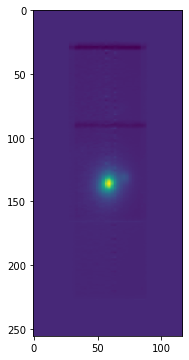

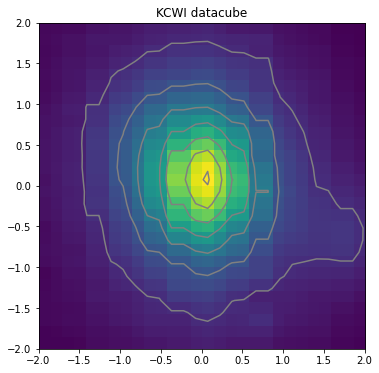

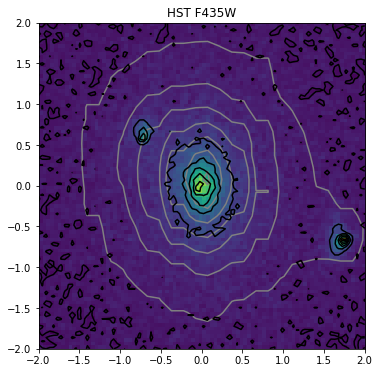

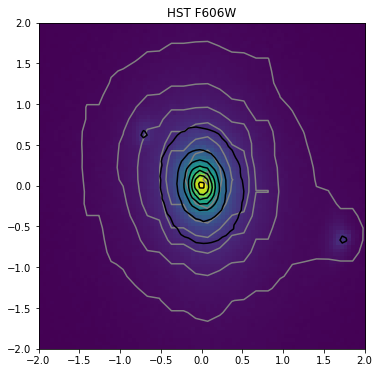

In [110]:
# import image, center, and crop

# effective radius in V band
# take photometry out to 4-5 r_eff
r_eff_V = 2.68

#######################################################################################
# kcwi datacube

file = file_dir + "/KCWI_J0037_icubes_mosaic_0.1457_2Dintegrated.fits"
hdu = fits.open(file)
kcwi_img = hdu[0].data
header = hdu[0].header

plt.clf()
plt.imshow(kcwi_img)
plt.pause(1)

# pixel scale
kcwi_scale = 0.147  # arcsec/pixel r_eff_V

# crop the image to ~ 2 arcsec radius
kcwi_2arc_img, _, _ = crop_center_image(kcwi_img, 2, kcwi_scale, 'argmax')

plt.clf()
plt.imshow(kcwi_2arc_img, origin='lower', extent=[-2,2,-2,2])#, extent=[0,50,0,50])
plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.title('KCWI datacube')
plt.pause(1)

#######################################################################################
# F435W cutout

# import image, center, and crop

file = f'/data/end_product/SLACS{obj_name}/cutouts{obj_name}_F435W.fits'
hdu = fits.open(file)
hstF435_img = hdu[0].data
header = hdu[0].header

# pixel scale
hst_scale = 0.0455 # or is it 0.0966 (PC vs WF3)

# crop the image to 2 arcsec
hstF435_2arc_img, _, _  = crop_center_image(hstF435_img, 2, hst_scale, 'center')

plt.clf()
plt.imshow(hstF435_2arc_img, origin='lower', extent=[-2,2,-2,2])
plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF435_2arc_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F435W')
plt.pause(1)

#######################################################################################
# F606W cutout

# import image, center, and crop

file = f'/data/end_product/SLACS/SDSSJ0037-0942/cutouts/{obj_name}_F606W.fits'
hdu = fits.open(file)
hstF606_cutout_img = hdu[0].data
header = hdu[0].header

# crop the image to 2 arcsec
hstF606_2arc_img, _, _  = crop_center_image(hstF606_cutout_img, 2, hst_scale, 'center')

plt.clf()
plt.imshow(hstF606_2arc_img,origin='lower', extent=[-2,2,-2,2])#, extent=[0,50,0,50])
plt.contour(kcwi_2arc_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF606_2arc_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F606W')
plt.pause(1)

# I'm going to crop the full HST F606 image

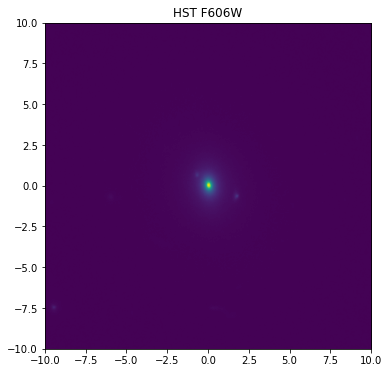

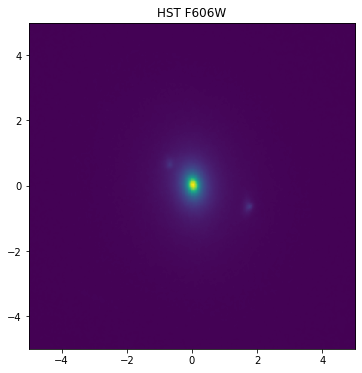

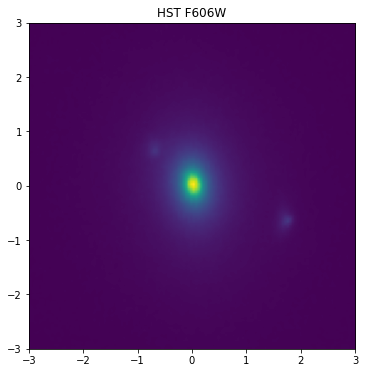

In [126]:
# import image, center, and crop

file = '/data/end_product/SLACS/SDSSJ0037-0942/image/SDSSJ0037-0942_F606W_u9qc89_sci.fits'
hdu = fits.open(file)
hstF606_img = hdu[0].data
header = hdu[0].header

# take the PA of the HST image
hst_PA = hdu[0].header['ORIENTAT']
hst_PA = -hst_PA

# rotate the image by the PA
hstF606_img = rotate(hstF606_img, hst_PA)

# see what wcs center is
#w = WCS(header)
#central_pixel_wcs = w.world_to_pixel(kcwi_center_wcs)
#central_pixel_wcs_x = central_pixel_wcs[0]
#central_pixel_wcs_y = central_pixel_wcs[1]

# take central pixel to be highest intensity
hstF606_centered_img, _, _  = crop_center_image(hstF606_img, hstF606_img.shape[0], hst_scale, 'center')

#plt.clf()
#plt.imshow(hstF606_img)
#plt.plot(central_pix_x, central_pix_y, 'ro', label='argmax center')
#plt.plot(central_pixel_wcs_x, central_pixel_wcs_y, 'go', label='wcs center')
#plt.legend()
plt.pause(1)

########################################################

# crop to 10 arcsec
hstF606_10arc_img, cen_10arc_x, cen_10arc_y  = crop_center_image(hstF606_img, 10, hst_scale, 'argmax')

# plot
left, right, upper, lower = [-10,10,-10,10]
plt.clf()
plt.imshow(hstF606_10arc_img, origin='lower', extent=[left, right, upper, lower])#, extent=[0,50,0,50])
#plt.plot(central_pix_x, central_pix_y, 'ro')
#plt.contour(kcwi_img, colors='grey', extent=[left, right, upper, lower])
#plt.contour(hstF606_img, colors='k', extent=[left, right, upper, lower])
plt.title('HST F606W')
plt.pause(1)

########################################################

# crop to 5 arcsec
hstF606_5arc_img, _, _  = crop_center_image(hstF606_img, 5, hst_scale, 'argmax')

# plot
left, right, upper, lower = [-5,5,-5,5]
plt.clf()
plt.imshow(hstF606_5arc_img, origin='lower', extent=[left, right, upper, lower])#, extent=[0,50,0,50])
#plt.plot(central_pix_x, central_pix_y, 'ro')
#plt.contour(kcwi_img, colors='grey', extent=[left, right, upper, lower])
#plt.contour(hstF606_img, colors='k', extent=[left, right, upper, lower])
plt.title('HST F606W')
plt.pause(1)

########################################################

# crop to 3 arcsec
hstF606_3arc_img, _, _  = crop_center_image(hstF606_img, 3, hst_scale, 'argmax')

# plot
left, right, upper, lower = [-3,3,-3,3]
plt.clf()
plt.imshow(hstF606_3arc_img, origin='lower', extent=[left, right, upper, lower])#, extent=[0,50,0,50])
#plt.plot(central_pix_x, central_pix_y, 'ro')
#plt.contour(kcwi_img, colors='grey', extent=[left, right, upper, lower])
#plt.contour(hstF606_img, colors='k', extent=[left, right, upper, lower])
plt.title('HST F606W')
plt.pause(1)

# Use 3 arcsec image to get the initial guess of PA and and ellipticity with find_galaxy

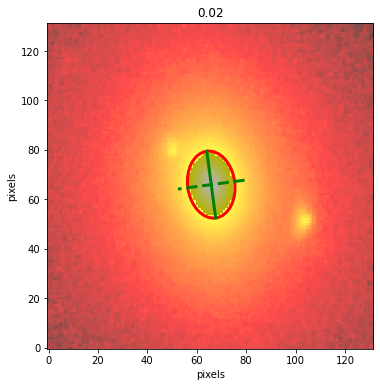

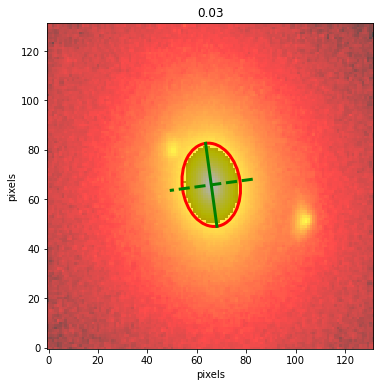

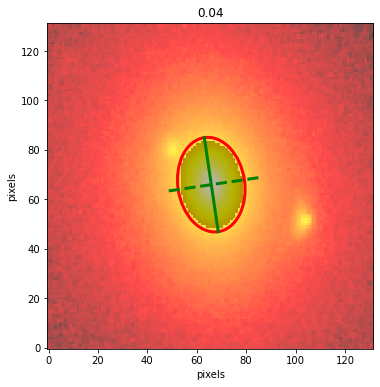

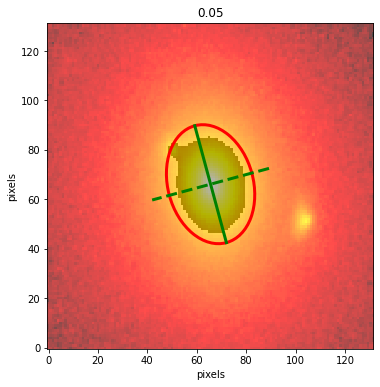

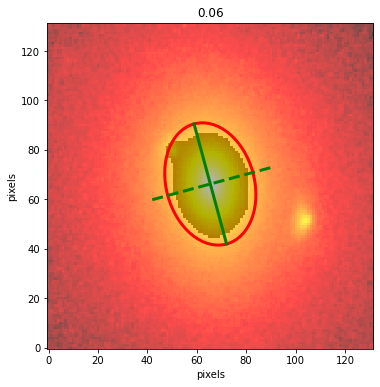

In [127]:
# sky, psf, scale, etc.

img = hstF606_3arc_img
scale = hst_scale

'''
I don't have a good selection for this? I'm guessing it's really like the noise level?
'''
minlevel = 0  # counts/pixel 
seeing_fwhm = 0.1 # arcsec
sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma

############################################################################################################################
# figure out the pixel fraction best to use

# take different values of pixel fractions
lower, upper, steps = (0.02, 0.06, 5)
fractions = np.linspace(lower, upper, steps)
    
eps_list = []
theta_list = []
cen_y_list = [] # don't need these, already centered it
cen_x_list = []

for frac in fractions:
    #print(f'Calculating fraction {frac}')
    frac = np.around(frac, 2)
    mid = np.around((upper+lower)/2, 2)
    plt.clf()
    #plt.clf()
    f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
    eps = f.eps
    theta = f.theta
    cen_y = f.ypeak
    cen_x = f.xpeak
    # assign to lists
    eps_list.append(eps)
    theta_list.append(theta)
    cen_y_list.append(cen_y)
    cen_x_list.append(cen_x)
    plt.title(f'{frac}')
    plt.pause(1)


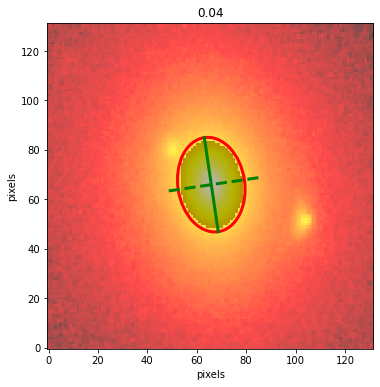

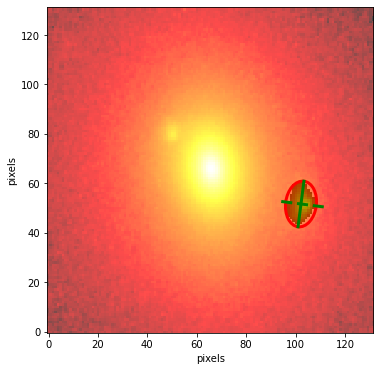

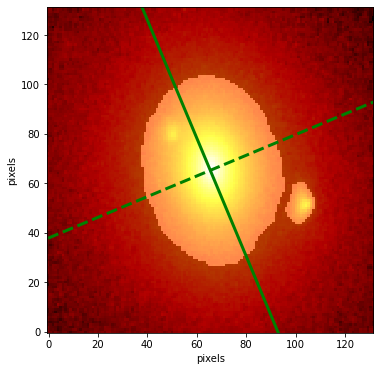

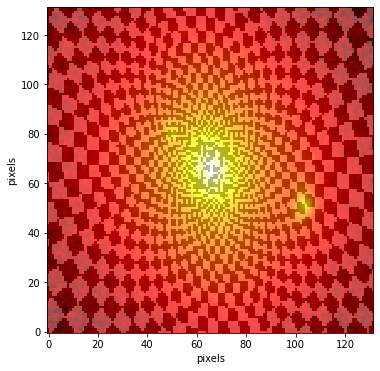

Iteration:1  chi2: 15.70  Nonzero: 6/12
Iteration:11  chi2: 1.615  Nonzero: 8/12
Iteration:21  chi2: 1.465  Nonzero: 8/12
Nonzero Gaussians: 7/12
Eliminating not useful Gaussians...
ngauss: 6          chi2: 1.451
Starting nonlinear fit...
Iteration:1  chi2: 1.451  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.77 seconds
  Total Iterations:  29
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  564
 Chi2: 1.449 
 STDEV: 0.05063 
 MEANABSDEV: 0.02747 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  2.477293e+04      2.83062     0.682872
  5.247700e+04      5.38355     0.674808
  1.213700e+05      10.0738     0.706444
  1.722553e+05      19.9193     0.735563
  9.926403e+04      46.4796     0.567077
  3.531536e+05      46.4796     1.0

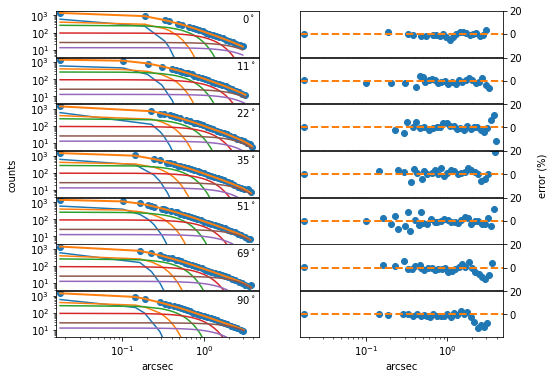

In [128]:
# Take fraction 0.04 and plug values in for initial guess with photoutils.isophote

frac=0.04

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
plt.title(f'{frac}')
plt.pause(1)
plt.clf()
f2 = find_galaxy(img, fraction=0.2, nblob=2, plot=1, quiet=True) # I was hoping I could just have find_galaxy give me other nblobs (lensed images)
plt.pause(1)
f3 = find_galaxy(img, fraction=0.2, nblob=3, plot=1, quiet=True)
plt.pause(1)
eps_0 = f.eps
theta_0 = f.theta
cen_y_0 = f.ypeak
cen_x_0 = f.xpeak

#print(eps, theta, cen_y, cen_x)

################################################
# Perform galaxy photometry

plt.clf()
s = sectors_photometry(img, eps, theta, cen_x, cen_y,
                       minlevel=minlevel, plot=1)
plt.pause(1)  # Allow plot to appear on the screen


############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12
# We'll need exposure time
hdul = fits.open('/data/end_product/SLACS/SDSSJ0037-0942/image/SDSSJ0037-0942_F606W_u9qc89_sci.fits')
hdu = hdul[0]
exp_time = hdu.header['EXPTIME']

# fit and plot
plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, #normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the outputs

# convert sigma from pixels to arcsec
sigma_pix = m.sol[1]
sigma = sigma_pix * scale

# q 
q = m.sol[2]

# deviations
absdev = m.absdev

# surface brightness
total_counts = m.sol[0]
# calculate peak surface brightness of each gaussian
peak_surf_br = total_counts/(2*np.pi*q*sigma_pix**2)
# correct for extinction and change to surface density
#### 4/19/22 I don't know where I got this surface brightness and extinction stuff...
# convert to johnson i band
# Here 20.840 is the photometric zeropint, 0.1 is a correction for infinite aperture to be applied 
# for surface brightness measurements, and AI is the extinction in the I-band
# dust extinction ~ 0.05 from https://irsa.ipac.caltech.edu/workspace/TMP_lFD64I_6198/DUST/SDSSJ0037-0942.v0002/extinction.html
AI = 0.05
iband_surf_br = 20.840 + 0.1 + 5 * np.log10(scale) + 2.5 * np.log10(exp_time) - 2.5 * np.log10(peak_surf_br) - AI
# convert to surface density (L_sol_I pc−2)
M_sol_I = 4.08
surf_density = (64800/np.pi)**2 * 10**( 0.4 * (M_sol_I - iband_surf_br))


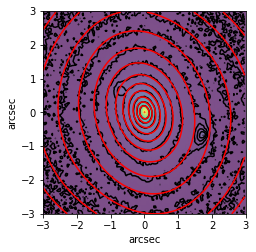

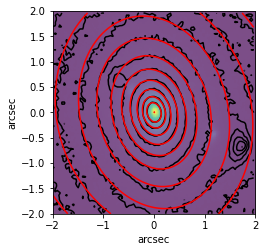

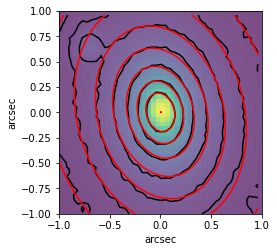

In [129]:
# Plot the results

# kinematics are to ~ 3 arcsec

n = int(np.around(3/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_3arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img, 
           origin='lower',
           extent = [-3, 3, -3, 3],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen

n = int(np.around(2/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_2arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(img_2arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img, 
           origin='lower',
           extent = [-2, 2, -2, 2],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen


n = int(np.around(1/scale))
img_cen = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
mge_print_contours(img_cen, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img_cen, 
           origin='lower',
           extent = [-1, 1, -1, 1],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen
    


# Looks reasonable. Now let's try to subtract the residual lensed images and do it on a larger image

/local/shawnknabel/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'color'


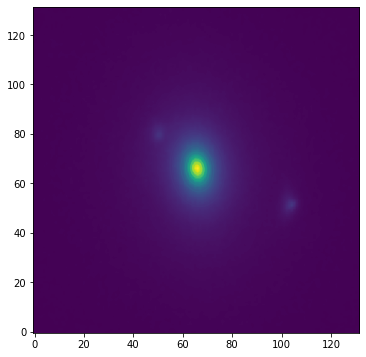

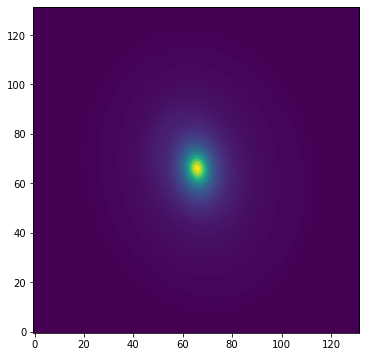

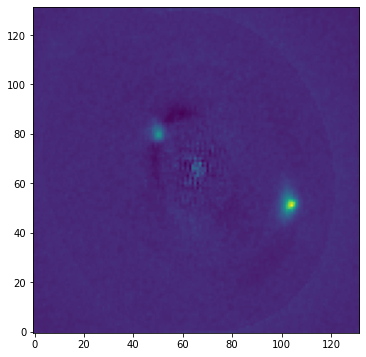

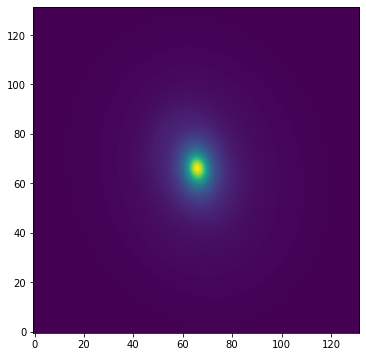

In [131]:
# take initial geometry from the central light and plot it
geometry = EllipseGeometry(x0=cen_x, y0=cen_y, sma=20, eps=eps, pa=np.radians(180-theta)) # annoying... theta is angle from negative x axis
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
plt.clf()
plt.imshow(img, origin='lower')
aper.plot(color='white')

# create the ellipse

ellipse = Ellipse(img, geometry)

# fit the model

isolist = ellipse.fit_image()

# build model image and look at residual
# take the mean of the lower left corner to fill the model instead of zeros
mean_dark = np.mean(img[0:30, 0:30])
model_image = build_ellipse_model(img.shape, isolist, fill=mean_dark)

residual = img - model_image

# plot

# image
plt.clf()
plt.imshow(img, origin='lower')
plt.contour(model_image, color='grey')
plt.pause(1)

# model image
plt.clf()
plt.imshow(model_image, origin='lower')
plt.contour(model_image)
plt.pause(1)

# residual
plt.clf()
plt.imshow(residual, origin='lower')
plt.pause(1)

# image without lensed images
img_wo_lensed = img - residual
plt.clf()
plt.imshow(img_wo_lensed, origin='lower')
plt.pause(1)


# Okay so I have a subtracted picture that is 3 arcsec. I need this to be 10 arcsec.

-0.1862366234427517


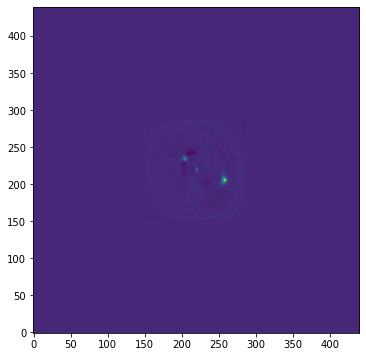

In [166]:
# pad the residual with 0s?

# 20 arcsec width (twice 10 arcsec radius) - 6 arcsec (twice 3 arcsec radius) = 14
# pad 7 arcsec on each side
pad = int(np.floor((hstF606_10arc_img.shape[0] - residual.shape[0])/2))
# pad value the average of lower left 20 of residual
mean_dark = np.mean(residual[:40,:40])
print(mean_dark)
zero_padded_residual_10arc = np.pad(residual, ((pad, pad), (pad, pad)) , mode='constant', constant_values=mean_dark)

plt.clf()
plt.imshow(zero_padded_residual_10arc, origin='lower')
plt.pause(1)

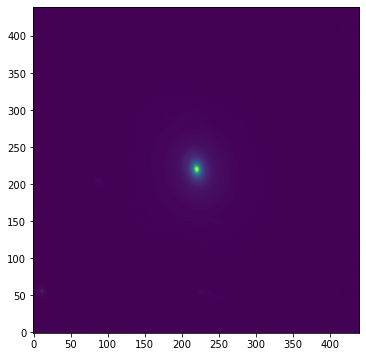

In [167]:
# subtract the 10 arcsec radius image

hstF606_10arc_img_wo_lensed = hstF606_10arc_img - zero_padded_residual_10arc

plt.clf()
plt.imshow(hstF606_10arc_img_wo_lensed, origin='lower')
plt.pause(1)

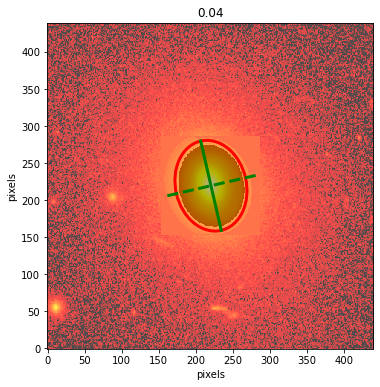

eps, theta, ceny, cenx, from first fit
0.2908913108531458 74.8376567769628 66 66
eps, theta, ceny, cenx, from subtracted fit
0.22662990150707263 77.0501229650227 220 220


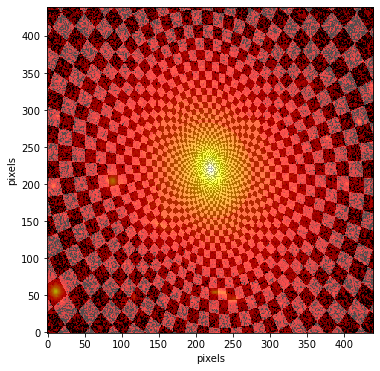

In [168]:
# Use this image to do the find_galaxy again and do galaxy photometry

img = hstF606_10arc_img_wo_lensed

frac=0.04

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
plt.title(f'{frac}')
plt.pause(1)
eps_ = f.eps
theta_ = f.theta
cen_y_ = f.ypeak
cen_x_ = f.xpeak

print('eps, theta, ceny, cenx, from first fit')
print(eps, theta, cen_y, cen_x)
print('eps, theta, ceny, cenx, from subtracted fit')
print(eps_, theta_, cen_y_, cen_x_)

################################################
# Perform galaxy photometry

plt.clf()
s = sectors_photometry(img, eps_, theta_, cen_x_, cen_y_,
                       minlevel=minlevel, plot=1)
plt.pause(1)  # Allow plot to appear on the screen

Iteration:1  chi2: 23.03  Nonzero: 9/12
Nonzero Gaussians: 8/12
Eliminating not useful Gaussians...
ngauss: 7          chi2: 21.17
ngauss: 6          chi2: 21.23
Starting nonlinear fit...
Iteration:1  chi2: 21.23  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.41 seconds
  Total Iterations:  8
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  806
 Chi2: 21.17 
 STDEV: 0.1599 
 MEANABSDEV: 0.05981 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  2.665945e+04      2.96373     0.679376
  6.919526e+04      5.89118     0.692895
  1.522027e+05      12.1712     0.691817
  2.239896e+05      26.8840     0.754563
  1.399081e+05      40.3573     0.860118
  5.036209e+05      112.402     0.836138
++++++++++++++++++++++++++++++++++++++++++++


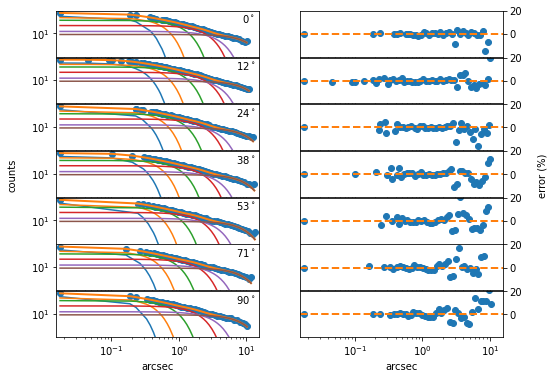

In [187]:
############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12
# We'll need exposure time
hdul = fits.open('/data/end_product/SLACS/SDSSJ0037-0942/image/SDSSJ0037-0942_F606W_u9qc89_sci.fits')
hdu = hdul[0]
exp_time = hdu.header['EXPTIME']

# fit and plot
plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps_,
                    ngauss=ngauss, sigmapsf=sigmapsf, #normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the outputs

# convert sigma from pixels to arcsec
sigma_pix = m.sol[1]
sigma = sigma_pix * scale

# q 
q = m.sol[2]

# deviations
absdev = m.absdev

# surface brightness
total_counts = m.sol[0]
# calculate peak surface brightness of each gaussian
peak_surf_br = total_counts/(2*np.pi*q*sigma_pix**2)
# correct for extinction and change to surface density
#### 4/19/22 I don't know where I got this surface brightness and extinction stuff...
# convert to johnson i band
# Here 20.840 is the photometric zeropint, 0.1 is a correction for infinite aperture to be applied 
# for surface brightness measurements, and AI is the extinction in the I-band
# dust extinction ~ 0.05 from https://irsa.ipac.caltech.edu/workspace/TMP_lFD64I_6198/DUST/SDSSJ0037-0942.v0002/extinction.html
AI = 0.05
iband_surf_br = 20.840 + 0.1 + 5 * np.log10(scale) + 2.5 * np.log10(exp_time) - 2.5 * np.log10(peak_surf_br) - AI
# convert to surface density (L_sol_I pc−2)
M_sol_I = 4.08
surf_density = (64800/np.pi)**2 * 10**( 0.4 * (M_sol_I - iband_surf_br))



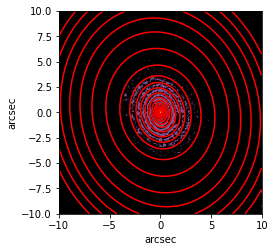

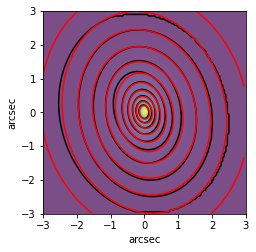

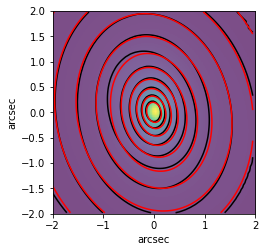

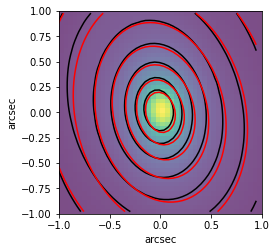

In [188]:
# Plot the results

n = int(np.around(10/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
#img_10arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(hstF606_10arc_img, theta_, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(hstF606_10arc_img, 
           origin='lower',
           extent = [-10, 10, -10, 10],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen

# kinematics are to ~ 3 arcsec

n = int(np.around(3/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_3arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(img_3arc, theta_, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img_3arc, 
           origin='lower',
           extent = [-3, 3, -3, 3],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen

n = int(np.around(2/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_2arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
plt.subplot(122)
mge_print_contours(img_2arc, theta_, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img_2arc, 
           origin='lower',
           extent = [-2, 2, -2, 2],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen


n = int(np.around(1/scale))
img_cen = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
mge_print_contours(img_cen, theta_, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img_cen, 
           origin='lower',
           extent = [-1, 1, -1, 1],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen
    


___________________

# Try out JAM model



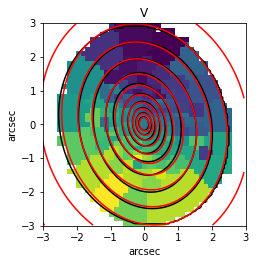

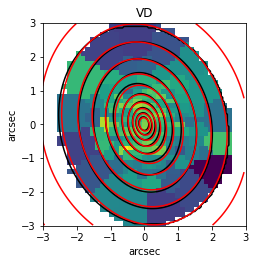

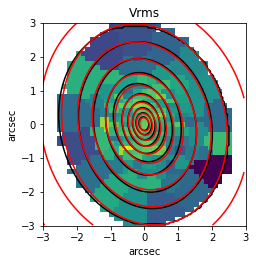

In [175]:
# read in kinematics files for view (3 arcsec, 21 pixels)

# velocity
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
# find barycenter velocity (intrinsic velocity)
center_axis_index = int(np.floor(V.shape[0]/2))
Vbary = V[center_axis_index, center_axis_index]
V = V - Vbary

# velocity dispersion
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')

# uncertainties
dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')

# rms velocity
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

# show each with surface brightness contours
# at three arcsec
n = int(np.around(3/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
img_3arc = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]

# V
plt.clf()
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(V, 
           extent = [-3, 3, -3, 3],
           origin='lower',
          alpha=1)
plt.title('V')
plt.pause(1)  # Allow plot to appear on the screen

# VD
plt.clf()
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(VD, 
           extent = [-3, 3, -3, 3],
           origin='lower',
          alpha=1)
plt.title('VD')
plt.pause(1)  # Allow plot to appear on the screen

# Vrms
plt.clf()
plt.subplot(122)
mge_print_contours(img_3arc, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(Vrms, 
           extent = [-3, 3, -3, 3],
           origin='lower',
          alpha=1)
plt.title('Vrms')
plt.pause(1)  # Allow plot to appear on the screen



# This is pretty, but we need it by bins, not by pixel.

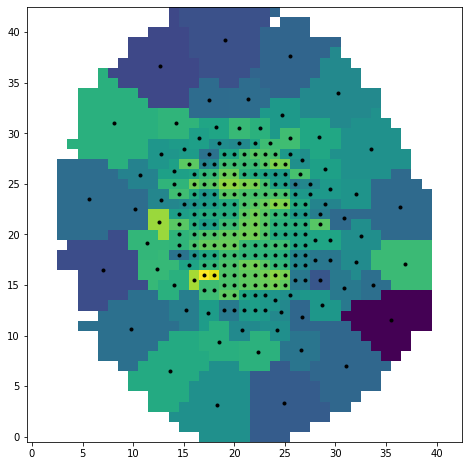

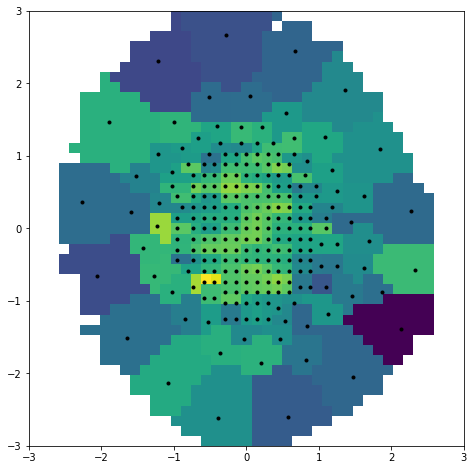

In [176]:
# bring in the velocity measurements and voronoi binning info

vel_meas = np.genfromtxt(file_dir + '/VD.txt') # Array with columns 0-3 - Vel, sigma, dv, dsigma
bins = np.arange(len(vel_meas))
V_bin = vel_meas[:,0]
V_bin = V_bin - Vbary # correct to barycenter velocity
VD_bin = vel_meas[:,1]
dV_bin = vel_meas[:,2]
dVD_bin = vel_meas[:,3]
Vrms_bin = np.sqrt(V_bin**2 + VD_bin**2)
dVrms_bin = np.sqrt((dV_bin*V_bin)**2 + (dVD_bin*VD_bin)**2)/Vrms_bin

# bring in vor_bins x, y, bin
vor_bins = np.genfromtxt(file_dir + '/voronoi_2d_binning_KCWI_J0037_icubes_mosaic_0.1457_output.txt')
vor_bins_df = pd.DataFrame(vor_bins, columns=['x','y','bins'])

# loop through all bins and attach central bins
x_cen_bins = []
y_cen_bins = []

for bins in bins:
    
    # take all x and y in this bin
    xs = vor_bins_df[vor_bins_df.bins==bins]['x']
    ys = vor_bins_df[vor_bins_df.bins==bins]['y']
  
    # take mean of these coords
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    
    x_cen_bins.append(x_mean)
    y_cen_bins.append(y_mean)

# convert to arrays    
x_cen_bins = np.array(x_cen_bins)
y_cen_bins = np.array(y_cen_bins)

# center
xbin_00 = x_cen_bins - center_axis_index
ybin_00 = y_cen_bins - center_axis_index

# convert to arcsec # kcwi!
xbin_arcsec = xbin_00 * kcwi_scale
ybin_arcsec = ybin_00 * kcwi_scale

# plot with pixels first
plt.figure(figsize=(8,8))
plt.imshow(Vrms, origin='lower')
plt.scatter(x_cen_bins, y_cen_bins, color='k', marker='.')

# plot with arcsec
extent = [-3,3,-3,3]
plt.figure(figsize=(8,8))
plt.imshow(Vrms, origin='lower', extent=extent)
plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')

# Hmmm... The center bins are not perfect here because the image isn't exactly 3x3 arcsec

<Figure size 576x432 with 0 Axes>

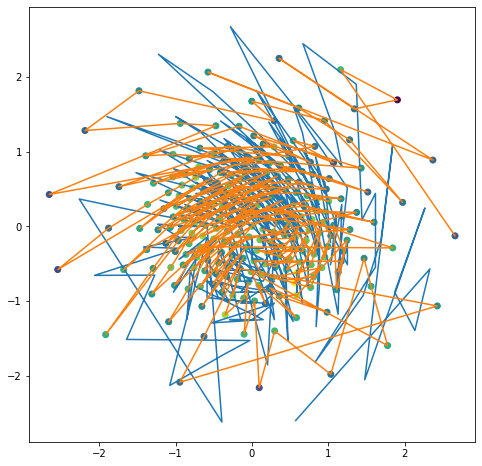

In [ ]:
'''
Rotate x and y bins by PA
'''

# set PA from mean photometry fitting
PA = theta

xbin = np.zeros(len(xbin_arcsec))
ybin = np.zeros(len(ybin_arcsec))
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    xbin[i], ybin[i] = rotate_points(xbin_arcsec[i], ybin_arcsec[i], PA) 

plt.clf()
plt.figure(figsize=(8,8))
plt.plot(xbin_arcsec, ybin_arcsec)
plt.plot(xbin, ybin)
plt.scatter(xbin,ybin,c=Vrms_bin)
plt.pause(1)
plt.pause(1)

<Figure size 576x432 with 0 Axes>

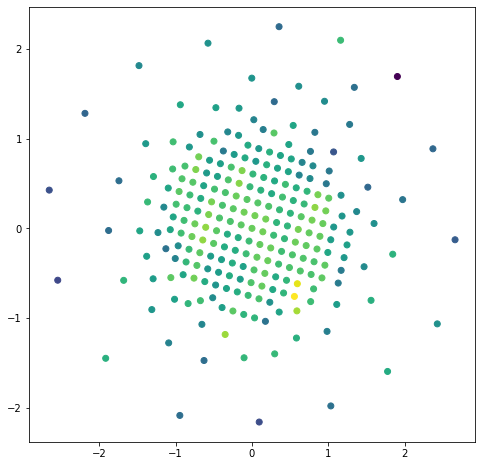

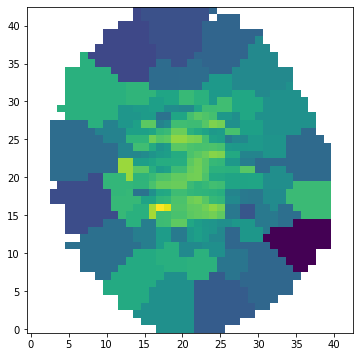

In [93]:
# compare this to the 2d map of vrms

# plot bins
plt.clf()
plt.figure(figsize=(8,8))
plt.scatter(xbin,ybin,c=Vrms_bin)
plt.pause(1)

# plot vrms map
plt.clf()
plt.imshow(Vrms, origin='lower')
plt.pause(1)

# Time for JAM! :)

####################################################
####################################################
Modeling moment zz
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.21
inc=50.0; beta[0]=0.20; kappa=1.00; M/L=3.15; BH=3.2e+08; chi2/DOF=2.41
Total mass MGE (MSun): 7.173e+11


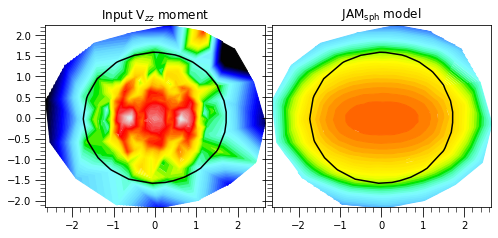

####################################################
Inclination of 60 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.10
inc=60.0; beta[0]=0.20; kappa=1.00; M/L=3.12; BH=3.1e+08; chi2/DOF=2.32
Total mass MGE (MSun): 7.096e+11


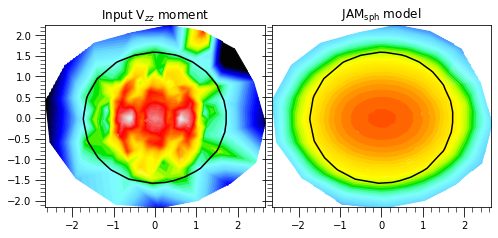

####################################################
Inclination of 70 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.18
inc=70.0; beta[0]=0.20; kappa=1.00; M/L=3.11; BH=3.1e+08; chi2/DOF=2.30
Total mass MGE (MSun): 7.081e+11


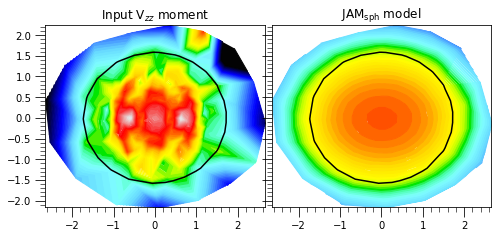

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.16
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=3.11; BH=3.1e+08; chi2/DOF=2.30
Total mass MGE (MSun): 7.076e+11


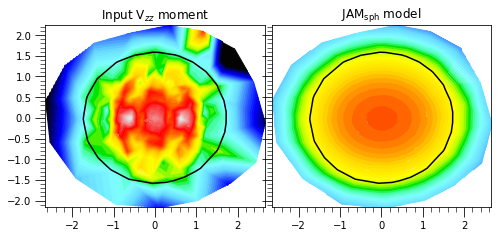

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.08
inc=90.0; beta[0]=0.20; kappa=1.00; M/L=3.11; BH=3.1e+08; chi2/DOF=2.29
Total mass MGE (MSun): 7.075e+11


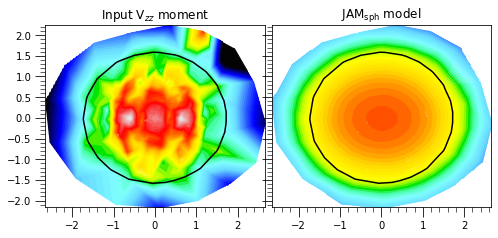

<Figure size 576x432 with 0 Axes>

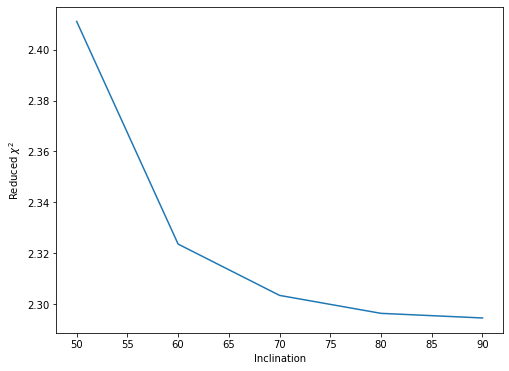

####################################################
####################################################
Modeling moment z
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.28
inc=50.0; beta[0]=0.20; kappa=1.47; M/L=1.00; BH=1.0e+08; chi2/DOF=5.78
Total mass MGE (MSun): 2.274e+11


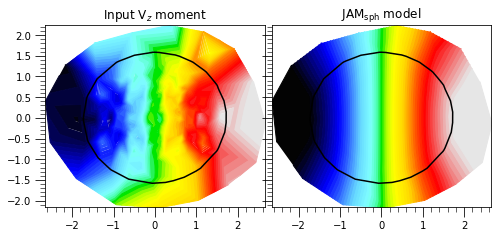

####################################################
Inclination of 60 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.15
inc=60.0; beta[0]=0.20; kappa=1.85; M/L=1.00; BH=1.0e+08; chi2/DOF=5.81
Total mass MGE (MSun): 2.274e+11


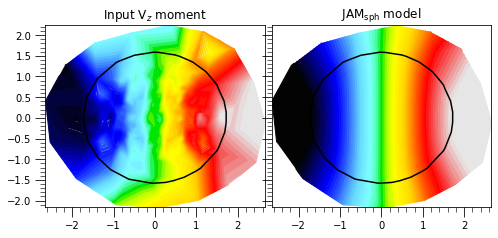

####################################################
Inclination of 70 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.18
inc=70.0; beta[0]=0.20; kappa=2.13; M/L=1.00; BH=1.0e+08; chi2/DOF=5.83
Total mass MGE (MSun): 2.274e+11


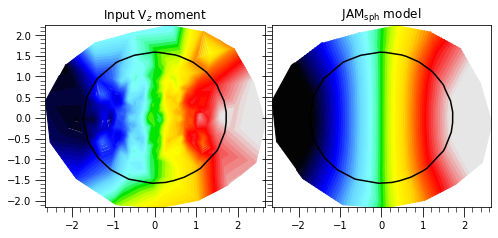

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.35
inc=80.0; beta[0]=0.20; kappa=2.30; M/L=1.00; BH=1.0e+08; chi2/DOF=5.84
Total mass MGE (MSun): 2.274e+11


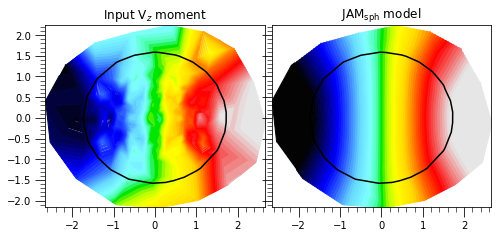

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.18
inc=90.0; beta[0]=0.20; kappa=2.36; M/L=1.00; BH=1.0e+08; chi2/DOF=5.84
Total mass MGE (MSun): 2.274e+11


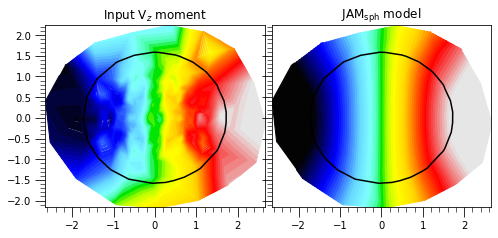

<Figure size 576x432 with 0 Axes>

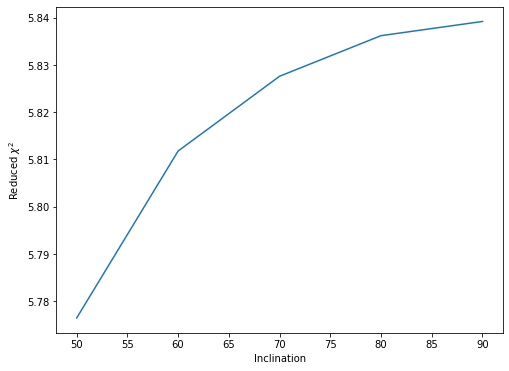

In [94]:

##############################################################################


'''
What do I do for inclination?
'''
inclinations = np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = sigmapsf
#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = hst_scale #0.8
goodbins = None

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')
    reduced_chi_squared = np.zeros((len(inclinations)))
    accepted_inclinations = np.copy(inclinations)
    i=0
    for inc in inclinations:
        print('####################################################')
        print(f'Inclination of {inc} degrees')

        inc_rad = np.radians(inc)
        qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
        if np.any(qintr_lum <= 0):
            print('This inclination does not work')
            accepted_inclinations = accepted_inclinations[1:]
            reduced_chi_squared = reduced_chi_squared[:-1]
            continue

        # The model is by design similar but not identical to the adopted kinematics!
        m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                         inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                         sigmapsf=sigmapsf, #normpsf=normpsf,
                         beta=beta, pixsize=pixsize,
                         moment=moment, goodbins=goodbins, 
                         align='sph', ml=None, nodots=True)
        plt.pause(3)
        plt.figure(2)
        #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
        reduced_chi_squared[i] = m.chi2
        i = i+1
    
    # plot the inclinations
    plt.clf()
    fig, axs = plt.subplots()
    axs.plot(accepted_inclinations, reduced_chi_squared)
    axs.set_ylabel(r'Reduced $\chi^2$')
    axs.set_xlabel('Inclination')
    plt.pause(1)

####################################################
####################################################
Modeling moment zz
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.85
inc=70.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.37
Total mass MGE (MSun): 6.211e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.87
inc=70.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.29
Total mass MGE (MSun): 6.115e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.86
inc=70.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.21
Total mass MGE (MSun): 6.009e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.88
inc=70.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.13
Total mass MGE (MSun): 5.894e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.08
inc=70.0; beta[0]=0.50; kappa=1.00; M/L=2.92; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.770e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 80 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.66
inc=80.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.36
Total mass MGE (MSun): 6.211e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.28
Total mass MGE (MSun): 6.112e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.78
inc=80.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.20
Total mass MGE (MSun): 6.005e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.78
inc=80.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.12
Total mass MGE (MSun): 5.889e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.01
inc=80.0; beta[0]=0.50; kappa=1.00; M/L=2.91; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.762e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 90 degrees
############
Beta of 0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.72
inc=90.0; beta[0]=0.10; kappa=1.00; M/L=3.14; BH=3.1e+08; chi2/DOF=2.35
Total mass MGE (MSun): 6.210e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.73
inc=90.0; beta[0]=0.20; kappa=1.00; M/L=3.09; BH=3.1e+08; chi2/DOF=2.27
Total mass MGE (MSun): 6.111e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.69
inc=90.0; beta[0]=0.30; kappa=1.00; M/L=3.04; BH=3.0e+08; chi2/DOF=2.20
Total mass MGE (MSun): 6.002e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.83
inc=90.0; beta[0]=0.40; kappa=1.00; M/L=2.98; BH=3.0e+08; chi2/DOF=2.12
Total mass MGE (MSun): 5.886e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.99
inc=90.0; beta[0]=0.50; kappa=1.00; M/L=2.91; BH=2.9e+08; chi2/DOF=2.06
Total mass MGE (MSun): 5.761e+11


<Figure size 576x432 with 0 Axes>

####################################################
####################################################
Modeling moment z
####################################################
Inclination of 30 degrees
This inclination does not work
####################################################
Inclination of 40 degrees
This inclination does not work
####################################################
Inclination of 50 degrees
This inclination does not work
####################################################
Inclination of 60 degrees
This inclination does not work
####################################################
Inclination of 70 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.84
inc=70.0; beta[0]=0.10; kappa=1.79; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.85
inc=70.0; beta[0]=0.20; kappa=2.22; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.81
inc=70.0; beta[0]=0.30; kappa=3.16; M/L=1.00; BH=1.0e+08; chi2/DOF=4.81
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.90
inc=70.0; beta[0]=0.40; kappa=5.83; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.05
inc=70.0; beta[0]=0.50; kappa=26.9; M/L=1.00; BH=1.0e+08; chi2/DOF=5.69
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 80 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.73
inc=80.0; beta[0]=0.10; kappa=1.88; M/L=1.00; BH=1.0e+08; chi2/DOF=4.87
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.20; kappa=2.42; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.76
inc=80.0; beta[0]=0.30; kappa=3.79; M/L=1.00; BH=1.0e+08; chi2/DOF=4.84
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.82
inc=80.0; beta[0]=0.40; kappa=11.0; M/L=1.00; BH=1.0e+08; chi2/DOF=5.01
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.00
inc=80.0; beta[0]=0.50; kappa=2.57e+03; M/L=1.00; BH=1.0e+08; chi2/DOF=12.2
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

####################################################
Inclination of 90 degrees
############
Beta of 0.1
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.73
inc=90.0; beta[0]=0.10; kappa=1.90; M/L=1.00; BH=1.0e+08; chi2/DOF=4.87
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.2
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.67
inc=90.0; beta[0]=0.20; kappa=2.49; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.3
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.74
inc=90.0; beta[0]=0.30; kappa=4.08; M/L=1.00; BH=1.0e+08; chi2/DOF=4.86
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.4
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.83
inc=90.0; beta[0]=0.40; kappa=15.2; M/L=1.00; BH=1.0e+08; chi2/DOF=5.17
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

############
Beta of 0.5
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 1.99
inc=90.0; beta[0]=0.50; kappa=2.67e+03; M/L=1.00; BH=1.0e+08; chi2/DOF=12.1
Total mass MGE (MSun): 1.977e+11


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

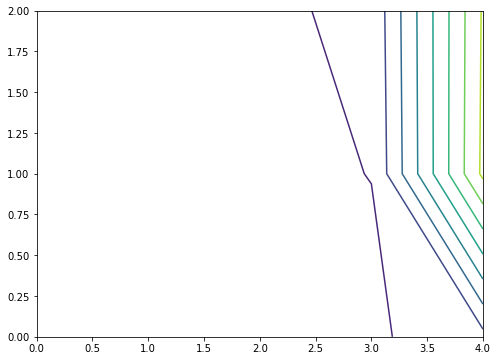

In [22]:



##############################################################################


'''
What do I do for inclination?
'''
inclinations = np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
'''
What do I do for black hole mass?
'''
mbh = 1e8 # Black hole mass in solar masses # not sure what to do here

# try different beta # TBD
betas = [0.1,0.2,0.3,0.4,0.5]
#beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = sigmapsf
#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = hst_scale #0.8
goodbins = None

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')
    reduced_chi_squared = np.zeros((len(inclinations), len(betas)))
    accepted_inclinations = np.copy(inclinations)
    i=0
    for inc in inclinations:
        print('####################################################')
        print(f'Inclination of {inc} degrees')

        inc_rad = np.radians(inc)
        qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
        if np.any(qintr_lum <= 0):
            print('This inclination does not work')
            accepted_inclinations = accepted_inclinations[1:]
            reduced_chi_squared = reduced_chi_squared[:-1]
            continue
        j=0
        for beta in betas:
            print('############')
            print(f'Beta of {beta}')
            beta = np.full_like(surf, beta)
            # The model is by design similar but not identical to the adopted kinematics!
            m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                             inc, mbh, distance, xbin, ybin, plot=False, data=data, errors=errors,
                             sigmapsf=sigmapsf, #normpsf=normpsf,
                             beta=beta, pixsize=pixsize,
                             moment=moment, goodbins=goodbins, 
                             align='sph', ml=None, nodots=True)
            plt.pause(3)
            plt.figure(2)
            #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
            reduced_chi_squared[i, j] = m.chi2
            j = j+1
        i = i+1

    # plot the reduced chi squared
    fig, axs = plt.subplots()
    axs.plot(reduced_chi_squared)

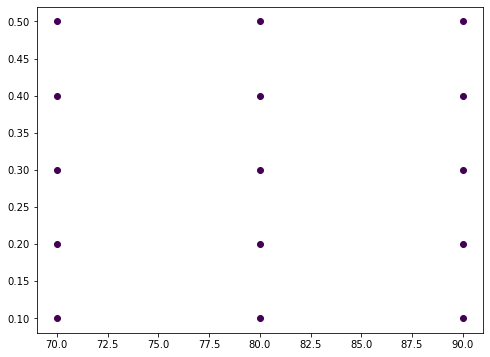

In [40]:
for i in range(len(accepted_inclinations)):
    for j in range(len(betas)):
        plt.scatter(accepted_inclinations[i], betas[j], c=reduced_chi_squared[i,j], cmap='viridis')

In [31]:
reduced_chi_squared = reduced_chi_squared[reduced_chi_squared>0]

In [32]:
inclinations = inclinations[7:]

plt.figure()

for i in range(len(inclinations)):
    for j in range(len(betas)):
        plt.contour(inclinations[i], betas[j], reduced_chi_squared[i,j])
        

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 576x432 with 0 Axes>

In [ ]:
reduced_chi_squared

In [ ]:
# try for a different value of beta
"""
    Copyright (C) 2019-2021, Michele Cappellari

    E-mail: michele.cappellari_at_physics.ox.ac.uk

    Updated versions of the software are available from my web page
    http://purl.org/cappellari/software

CHANGELOG
---------

V1.1.0: MC, Oxford, 16 July 2020
    - Compute both Vrms and LOS velocity.
V1.0.1: MC, Oxford, 21 April 2020
    - Made a separate file
V1.0.0: Michele Cappellari, Oxford, 08 November 2019
    - Written and tested

"""

##############################################################################

#np.random.seed(123)
#xbin, ybin = np.random.uniform(low=[-55, -40], high=[55, 40], size=[1000, 2]).T

'''
What do I do for inclination?
'''
inclinations = np.arange(40, 100, 10)          # Assumed galaxy inclination

#r = np.sqrt(xbin**2 + (ybin/np.cos(np.radians(inc)))**2) # Radius in the plane of the disk
#a = 40                                                   # Scale length in arcsec
#vr = 2000*np.sqrt(r)/(r + a)                             # Assumed velocity profile (v_c of Hernquist 1990)
#vel = vr * np.sin(np.radians(inc))*xbin/r                # Projected velocity field
#sig = 8700/(r + a)                                       # Assumed velocity dispersion profile
#rms = np.sqrt(vel**2 + sig**2)                           # Vrms field in km/s

# Until here I computed some fake input kinematics to fit with JAM.
# Ina real application, instead of the above lines one will read the
# measured stellar kinematics, e.g. from integral-field spectroscopy

'''
Open kinematics maps
'''
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')
# compute rms velocity
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

'''
x and y bins (pixels)
'''
# write the grid of xbins and ybins with (0,0) at the center and the x-axis corresponding to major axis
# set x and y bins so that center is (0, 0)
size = V.shape[0]

xbin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale
ybin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale

# set PA from mean photometry fitting
PA = theta

# set new arrays with the rotated coordinates
xbin_rot = np.zeros(size)
ybin_rot = np.zeros(size)
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    for j in range(len(ybin_arcsec)):
        x_new, y_new = rotate_points(xbin_arcsec[i], ybin_arcsec[j], PA)
        xbin_rot[i] = x_new
        ybin_rot[j] = y_new
        
xbin, ybin = np.meshgrid(xbin_rot, ybin_rot)

'''
flatten data and bins
'''
V = V.flatten()
dV = dV.flatten()
VD = VD.flatten()
dVD = dVD.flatten()
Vrms = Vrms.flatten()
dVrms = dVrms.flatten()
xbin = xbin.flatten()
ybin = ybin.flatten()
        
'''
surface density
'''
# take the surface density, etc from mge
surf = surf_density # surf_dens_list[2] <- this was with psf 0.75
sigma = sigma #sigma_list[2]
qObs = q #q_list[2]

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
mbh = 1e8 # Black hole mass in solar masses

# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.5)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C

surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = 0.75
sigmapsf = np.atleast_1d(sigmapsf)
sigmaX2 = sigma_lum**2 + sigmapsf[:, None]**2
sigmaY2 = (sigma_lum*qobs_lum)**2 + sigmapsf[:, None]**2
#normpsf = [0.7, 0.3]
pixsize = scale #0.8
goodbins = np.isfinite(Vrms) # take finite data

'''
run JAM
'''
# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

reduced_chi_squared = np.zeros((len(inclinations)))
i=0
for inc in inclinations:
    print('####################################################')
    print(f'Inclination of {inc} degrees')
    #for moment, data, errors in zip(['zz', 'z'], [Vrms, V], [dVrms, dV]):
    #    print()
    #    print(f'Moment {moment}')
    moment = 'zz'
    data = Vrms
    errors = dVrms
    
    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared[i] = m.chi2
    i = i+1

# plot the inclinations
fig, axs = plt.subplots()
axs.plot(inclinations, reduced_chi_squared)
axs.set_ylabel(r'Reduced $\chi^2$')
axs.set_xlabel('Inclination')

# take it at 40 degrees and vary beta

In [ ]:
# try for a different value of beta
"""
    Copyright (C) 2019-2021, Michele Cappellari

    E-mail: michele.cappellari_at_physics.ox.ac.uk

    Updated versions of the software are available from my web page
    http://purl.org/cappellari/software

CHANGELOG
---------

V1.1.0: MC, Oxford, 16 July 2020
    - Compute both Vrms and LOS velocity.
V1.0.1: MC, Oxford, 21 April 2020
    - Made a separate file
V1.0.0: Michele Cappellari, Oxford, 08 November 2019
    - Written and tested

"""

##############################################################################

#np.random.seed(123)
#xbin, ybin = np.random.uniform(low=[-55, -40], high=[55, 40], size=[1000, 2]).T

'''
What do I do for inclination?
'''
#inclinations = [40.,45.,50.,55.,60.,65.,70.,75.,80.,85.,90.]          # Assumed galaxy inclination
inc = 40.

#r = np.sqrt(xbin**2 + (ybin/np.cos(np.radians(inc)))**2) # Radius in the plane of the disk
#a = 40                                                   # Scale length in arcsec
#vr = 2000*np.sqrt(r)/(r + a)                             # Assumed velocity profile (v_c of Hernquist 1990)
#vel = vr * np.sin(np.radians(inc))*xbin/r                # Projected velocity field
#sig = 8700/(r + a)                                       # Assumed velocity dispersion profile
#rms = np.sqrt(vel**2 + sig**2)                           # Vrms field in km/s

# Until here I computed some fake input kinematics to fit with JAM.
# Ina real application, instead of the above lines one will read the
# measured stellar kinematics, e.g. from integral-field spectroscopy

'''
Open kinematics maps
'''
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')
# compute rms velocity
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

'''
x and y bins (pixels)
'''
# write the grid of xbins and ybins with (0,0) at the center and the x-axis corresponding to major axis
# set x and y bins so that center is (0, 0)
size = V.shape[0]

xbin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale
ybin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale

# set PA from mean photometry fitting
PA = theta

# set new arrays with the rotated coordinates
xbin_rot = np.zeros(size)
ybin_rot = np.zeros(size)
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    for j in range(len(ybin_arcsec)):
        x_new, y_new = rotate_points(xbin_arcsec[i], ybin_arcsec[j], PA)
        xbin_rot[i] = x_new
        ybin_rot[j] = y_new
        
xbin, ybin = np.meshgrid(xbin_rot, ybin_rot)

'''
flatten data and bins
'''
V = V.flatten()
dV = dV.flatten()
VD = VD.flatten()
dVD = dVD.flatten()
Vrms = Vrms.flatten()
dVrms = dVrms.flatten()
xbin = xbin.flatten()
ybin = ybin.flatten()
        
'''
surface density
'''
# take the surface density, etc from mge
surf = surf_density # surf_dens_list[2] <- this was with psf 0.75
sigma = sigma #sigma_list[2]
qObs = q #q_list[2]

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
mbh = 1e8 # Black hole mass in solar masses

# try different beta # TBD
betas = np.arange(0.05, 0.5, 0.05)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C

surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = 0.75
sigmapsf = np.atleast_1d(sigmapsf)
sigmaX2 = sigma_lum**2 + sigmapsf[:, None]**2
sigmaY2 = (sigma_lum*qobs_lum)**2 + sigmapsf[:, None]**2
#normpsf = [0.7, 0.3]
pixsize = scale #0.8
goodbins = np.isfinite(Vrms) # take finite data

'''
run JAM
'''
# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

reduced_chi_squared = np.zeros((len(betas)))
i=0
for beta in betas:
    print('####################################################')
    print(f'Beta={beta}')
    beta = np.full_like(surf, beta)
    #for moment, data, errors in zip(['zz', 'z'], [Vrms, V], [dVrms, dV]):
    #    print()
    #    print(f'Moment {moment}')
    moment = 'zz'
    data = Vrms
    errors = dVrms
    
    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared[i] = m.chi2
    i = i+1

# plot the inclinations
fig, axs = plt.subplots()
axs.plot(betas, reduced_chi_squared)
axs.set_ylabel(r'Reduced $\chi^2$')
axs.set_xlabel(r'$\beta$')

In [ ]:
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
plt.imshow(V)

In [ ]:
#The image is flipped vertically!!!

In [ ]:
V = V.flatten()
V = V.reshape(43,43)
plt.imshow(V)

#Does it get flipped in JAM?